In [1]:
import json
import pandas as pd
import numpy as np

import re

from sqlalchemy import create_engine
import psycopg2

# from config import db_password

import time

# 1. Create a function that takes in three arguments;
# Wikipedia data, Kaggle metadata, and MovieLens rating data (from Kaggle)

def extract_transform_load():
    # 2. Read in the kaggle metadata and MovieLens ratings CSV files as Pandas DataFrames.
    kaggle_metadata = pd.read_csv(f'{file_dir}movies_metadata.csv', low_memory=False)
    ratings = pd.read_csv(f'{file_dir}ratings.csv')

    # 3. Open and read the Wikipedia data JSON file.
    with open(f'{file_dir}/wikipedia-movies.json', mode='r') as file:
        wiki_movies_raw = json.load(file)
    
    # 4. Read in the raw wiki movie data as a Pandas DataFrame.
    wiki_movies_df = pd.DataFrame(wiki_movies_raw)
    
    # 5. Return the three DataFrames
    return wiki_movies_df, kaggle_metadata, ratings

# 6 Create the path to your file directory and variables for the three files. 
file_dir = '/Users/soha/Movies-ETL/'
# Wikipedia data
wiki_file = f'{file_dir}/wikipedia_movies.json'
# Kaggle metadata
kaggle_file = f'{file_dir}/movies_metadata.csv'
# MovieLens rating data.
ratings_file = f'{file_dir}/ratings.csv'

# 7. Set the three variables in Step 6 equal to the function created in Step 1.
wiki_file, kaggle_file, ratings_file = extract_transform_load()

In [2]:
#  Add the clean movie function that takes in the argument, "movie".
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    # combine alternate titles into one list
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles
    
    # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')
    
    
    return movie

In [3]:
# 1. Add the function that takes in three arguments;
# Wikipedia data, Kaggle metadata, and MovieLens rating data (from Kaggle)

def extract_transform_load():
    # Read in the kaggle metadata and MovieLens ratings CSV files as Pandas DataFrames.
    kaggle_metadata = pd.read_csv(f'{file_dir}movies_metadata.csv', low_memory=False)
    ratings = pd.read_csv(f'{file_dir}ratings.csv')

    # Open and read the Wikipedia data JSON file.
    with open(f'{file_dir}/wikipedia-movies.json', mode='r') as file:
        wiki_movies_raw = json.load(file)
    
    # Write a list comprehension to filter out TV shows.
    wiki_movies = [movie for movie in wiki_movies_raw
               if 'No. of episodes' not in movie
                  and 'Series' not in movie
                  and 'Television series' not in movie
                  and ('Director' in movie or 'Directed by' in movie)
                  and 'imdb_link' in movie]

    # Write a list comprehension to iterate through the cleaned wiki movies list
    # and call the clean_movie function on each movie.
    cleaned_wiki_movies = [clean_movie(movie) for movie in wiki_movies]

    # Read in the cleaned movies list from Step 4 as a DataFrame.
    wiki_movies_df = pd.DataFrame(cleaned_wiki_movies)

    # Write a try-except block to catch errors while extracting the IMDb ID using a regular expression string and
    #  dropping any imdb_id duplicates. If there is an error, capture and print the exception.
    try:
        # Extracting IMDb ID
        wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
        # Dropping duplicates of IMDb IDs
        wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
        
    except:
        print("An error has occurred.")

    #  Write a list comprehension to keep the columns that don't have null values from the wiki_movies_df DataFrame.
    wiki_column_names = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df)]
    wiki_movies_df = wiki_movies_df[wiki_column_names]

    # Create a variable that will hold the non-null values from the “Box office” column.
    box_office = wiki_movies_df['Box office'].dropna()
    
    # Convert the box office data created in Step 8 to string values using the lambda and join functions.
    box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)

    # Write a regular expression to match the six elements of "form_one" of the box office data.
    form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
    
    # Write a regular expression to match the three elements of "form_two" of the box office data.
    form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'

    # Add the parse_dollars function.
    def parse_dollars(s):
        # if s is not a string, return NaN
        if type(s) != str:
            return np.nan

        # if input is of the form $###.# million
        if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

            # remove dollar sign and " million"
            s = re.sub('\$|\s|[a-zA-Z]','', s)

            # convert to float and multiply by a million
            value = float(s) * 10**6

            # return value
            return value

        # if input is of the form $###.# billion
        elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

            # remove dollar sign and " billion"
            s = re.sub('\$|\s|[a-zA-Z]','', s)

            # convert to float and multiply by a billion
            value = float(s) * 10**9

            # return value
            return value

        # if input is of the form $###,###,###
        elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

            # remove dollar sign and commas
            s = re.sub('\$|,','', s)

            # convert to float
            value = float(s)

            # return value
            return value

        # otherwise, return NaN
        else:
            return np.nan
        
        
    # Clean the box office column in the wiki_movies_df DataFrame.
    wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
    wiki_movies_df.drop('Box office', axis=1, inplace=True)
    
    
    # Clean the budget column in the wiki_movies_df DataFrame.
    ## Create a variable that will hold the non-null values from the “Budget” column.
    budget = wiki_movies_df['Budget'].dropna()
    ## Convert the budget data created in the step above to string values using the lambda and join functions.
    budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)
    ## Remove any values between a dollar sign and a hyphen: (for budgets given in ranges)
    budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
    ## Remove citation references
    budget = budget.str.replace(r'\[\d+\]\s*', '')
    ##
    wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
    ## Dropping the original Budget column
    wiki_movies_df.drop('Budget', axis=1, inplace=True)
    

    # Clean the release date column in the wiki_movies_df DataFrame.
    ## Keep non-null values and convert list to string in the release date column
    release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    ## Writing regular expressions for the 4 forms:
    ### January 1, 2000 > month, dd, yyyy
    ### 2000-01-01 > yyyy-mm-dd and yyyy/mm/dd
    ### January 2000 > month yyyy
    ### Four-digit year > yyyy
    date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
    date_form_two = r'\d{4}.[01]\d.[0123]\d'
    date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
    date_form_four = r'\d{4}'
    ## Parse the dates
    wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)
    

    # Clean the running time column in the wiki_movies_df DataFrame.
    ## Keep non-null values and convert list to string in the running time column
    running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    ## Parsing entries where hours and minutes are listed separately
    running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
    ## Convert strings into numeric values
    running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
    ## Converting the hour capture groups and minute capture groups 
    ## to minutes if the pure minutes capture group is zero:
    wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)
    ## Dropping the original Running Time column
    wiki_movies_df.drop('Running time', axis=1, inplace=True)
    
     
    # 2. Clean the Kaggle metadata.
    # Checking if all columns came in as correct data types
    kaggle_metadata.dtypes
    # To check if all the values in this column are either True or False
    # Looking at the 'adult' column:
    kaggle_metadata['adult'].value_counts()
    # To remove bad data
    kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]
    # Keep rows where adult column is False, and then drop the adult column.
    kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')
    # Looking at the 'video' column:
    kaggle_metadata['video'].value_counts()
    # To convert
    kaggle_metadata['video'] == 'True'
    # Assign the Boolean column created above back to 'video'
    kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'
    # NOTE: Setting errors= to 'raise', so we will know
    # if there is any data that cannot be converted to numbers
    kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
    kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
    kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')
    # Converting release_date to datetime
    kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])
    

    # 3. Merged the two DataFrames into the movies DataFrame.
    movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki','_kaggle'])

    
    # 4. Drop unnecessary columns from the merged DataFrame.
    
    ## (a) Figuring out which columns are unnecessary:
    
    ### Outline when starting:
    ### Competing data:
    ### Wiki                     Movielens                Resolution
    ### --------------------------------------------------------------------------
    ### title_wiki               title_kaggle
    ### running_time             runtime
    ### budget_wiki              budget_kaggle
    ### box_office               revenue
    ### release_date_wiki        release_date_kaggle
    ### Language                 original_language
    ### Production company(s)    production_companies
    
    ### TITLES: 
    ### Start by looking at some titles:
    movies_df[['title_wiki','title_kaggle']]
    ### Look at the rows where titles don't match:
    movies_df[movies_df['title_wiki'] != movies_df['title_kaggle']][['title_wiki','title_kaggle']]
    ### Both options look pretty good, but Kaggle data looks a bit more consistent.
    ### Let's confirm there aren't any missing titles in Kaggle data.
    ### Show any rows where title_kaggle is empty:
    movies_df[(movies_df['title_kaggle'] == '') | (movies_df['title_kaggle'].isnull())]
    ### No results were returned, so we can just drop the Wikipedia titles.
    
    ### RUNTIME:
    ### NOTE: A scatter plot will give us a sense of how similar the columns are to each other. 
    ### If the two columns are exactly the same, we would see a scatter plot of a perfectly straight line.
    ### Since it is merged data, missing values are expected. Scatter plots won't show null values, 
    ### so we need to fill them in with zeros when we're making out plots to get the whole picture.
    ### Fill in missing values with zero and make the scatter plot:
    movies_df.fillna(0).plot(x='running_time', y='runtime', kind='scatter')
    ### NOTE: There are more data points on the origin of the Y axis than on the origin of X axis. 
    ### Since X axis is Wikipedia and Y axis is Kaggle, this means there are more missing entries in Wikipedia 
    ### data set than in the Kaggle data set. Also, most of the runtimes are pretty close to each other but the
    ### Wikipedia data has some outliers, so the Kaggle data is probably a better choice here.
    ### However, we cna also see from the scatter plot that there are movies where Kaggle has 0 for the runtime 
    ### but Wikipedia has data, so we'll fill in the gaps with Wikipedia data.
    
    ### BUDGET:
    ### Make scatter plot to compare values in numeric budget_wiki and budget_kaggle:
    movies_df.fillna(0).plot(x='budget_wiki',y='budget_kaggle', kind='scatter')
    ### Questions to consider (while looking at scatter plots):
    ### (1) Which dataset seems to have more outliers?
    ### (2) Which dataset seems to have more missing data points?
    ### (3) If we were to fill in the missing data points of one set with the other, which would be more likely 
    ### to give us consistent data?
    ### (4) Is it better to start with a base of consistent data and fill in missing points with outliers 
    ### or fill in missing points with more consistent data?
    ### NOTE: The Wikipedia data appears to have more outliers compared to the Kaggle data. 
    ### However, there are quite a few movies with no data in the Kaggle column, while Wikipedia does have 
    ### budget data. Therefore, we'll fill in the gaps with Wikipedia's data.
    
    ### BOX OFFICE:
    # Make a scatter plot for the numeric box office and revenue columns:
    movies_df.fillna(0).plot(x='box_office', y='revenue', kind='scatter')
    ### Looks pretty close, but we might be getting thrown off by the scale of that large data point.
    ### Look at it for everything less than $1 billion:
    movies_df.fillna(0)[movies_df['box_office'] < 10**9].plot(x='box_office', y='revenue', kind='scatter')
    ### This looks similar to what we've seen for budget, so we'll make the same decision:
    ### keep the Kaggle data, but fill in the zeros with Wikipedia data.
    
    ### RELEASE DATE:
    ### Since data isn't numeric, cannot use scatter plot.
    ### Instead, using regular line plot, and changing style to only put dots:
    movies_df[['release_date_wiki','release_date_kaggle']].plot(x='release_date_wiki', y='release_date_kaggle', style='.')
    ### Investigate the wild outlier at 2006:
    #### Choose some rough cutoff dates to single out that one movie. Look for any movie whose release date 
    #### acc. to Wikipedia is after 1996, but whose release date acc. to Kaggle is before 1965.
    movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')]
    ### Looks like The Holiday in Wikipedia data got merged with From Here to Eternity. Drop that row:
    #### Get the index of that row with the following:
    movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index
    #### Drop that row like so:
    movies_df = movies_df.drop(movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index)
    ### See if there are any null values:
    movies_df[movies_df['release_date_wiki'].isnull()]
    ### NOTE: Wikipedia data is missing release dates for 11 movies. Kaggle data isn't missing any. 
    ### So, we will just drop the Wikipedia data.
    
    ### LANGUAGE:
    ### Compare value counts of each: 
    ### Following will throw an error, because some of the language data points are stored as lists:
    ### movies_df['Language'].value_counts()
    ### The error reads: TypeError: unhashable type: 'list'
    ### Convert lists in Language to tuples so that value_counts() will work:
    movies_df['Language'].apply(lambda x: tuple(x) if type(x) == list else x).value_counts(dropna=False)
    ### For Kaggle data, there are no lists, so we can just run value_counts():
    movies_df['original_language'].value_counts(dropna=False)
    ### NOTE: While Wikipedia data has more info about multiple languages, Kaggle data is already in a consistent 
    ### and usable format. Parsing Wikipedia data may create too many difficulties to make it worthwhile.
    
    ### PRODUCTION COMPANIES:
    ### Look at small number of samples:
    movies_df[['Production company(s)','production_companies']]
    ### NOTE: Kaggle data is much more consistent. It would be difficult, if not impossible, to translate 
    ### Wikipedia data into same format. Drop Wikipedia data.
    
    ### Outline finally:
    ### Competing data:
    ### Wiki                     Movielens                Resolution
    ### --------------------------------------------------------------------------
    ### title_wiki               title_kaggle             Drop Wikipedia.
    ### running_time             runtime                  Keep Kaggle; fill in 
    ###                                                   zeros with Wikipedia data.
    ### budget_wiki              budget_kaggle            Keep Kaggle; fill in
    ###                                                   zeros with Wikipedia data.
    ### box_office               revenue                  Keep Kaggle; fill in
    ###                                                   zeros with Wikipedia data.
    ### release_date_wiki        release_date_kaggle      Drop Wikipedia.
    ### Language                 original_language        Drop Wikipedia.
    ### Production company(s)    production_companies     Drop Wikipedia.

    
    ## (b) Dropping the unnecessary columns:
    ### Drop the title_wiki, release_date_wiki, Language and Production company(s) columns:
    movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Production company(s)'], inplace=True)


    # 5. Add in the function to fill in the missing Kaggle data.
    ## The function fills in missing data for a column pair and then drops the redundant column:
    def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
        df[kaggle_column] = df.apply(
            lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
            , axis=1)
        df.drop(columns=wiki_column, inplace=True)

        
    # 6. Call the function in Step 5 with the DataFrame and columns as the arguments.
    ## Run function for the 3 column pairs we decided to fill in zeros.
    fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
    fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
    fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')
    movies_df

    
    # 7. Filter the movies DataFrame for specific columns.
    ## Check that there aren't any columns with only one value, since that doesn't really provide any information.
    ### Convert lists to tuples first (for value_counts() ) to work:
    for col in movies_df.columns:
        lists_to_tuples = lambda x: tuple(x) if type(x) == list else x
        value_counts = movies_df[col].apply(lists_to_tuples).value_counts(dropna=False)
        num_values = len(value_counts)
        if num_values == 1:
            print(col)    
    ### Run value_counts() on 'video':
    movies_df['video'].value_counts(dropna=False)
    ### NOTE: Since it is false for every row, we don't need to include this column.


    # 8. Rename the columns in the movies DataFrame.
    ## Reorder the columns so that similar columns are near each other:
    movies_df = movies_df.loc[:, ['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
                       'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
                       'genres','original_language','overview','spoken_languages','Country',
                       'production_companies','production_countries','Distributor',
                       'Producer(s)','Director','Starring','Cinematography','Editor(s)','Writer(s)','Composer(s)','Based on'
                      ]]
    ## Rename the columns to be consistent:
    movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Cinematography':'cinematography',
                  'Editor(s)':'editors',
                  'Writer(s)':'writers',
                  'Composer(s)':'composers',
                  'Based on':'based_on'
                 }, axis='columns', inplace=True)

    
    # 9. Transform and merge the ratings DataFrame.
    
    ## Reasonability Checks:
    ## Since dataset has so many rows, we need to set the null_counts option to True:
    ratings.info(null_counts=True)
    ## Specifying that origin is 'unix' and the time unit is seconds:
    pd.to_datetime(ratings['timestamp'], unit='s')
    ## Assign output to timestamp column:
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
    ## Look at the statistics of the actual ratings:
    ## Look at a histogram of the rating distributions. Then print out some stats on central tendency and spread.
    ### pd.options.display.float_format = '{:20,.2f}'.format
    ### ratings['rating'].plot(kind='hist')
    ### ratings['rating'].describe()
    
    ## Use a groupby on the "movieId" and "rating" columns and take the count for each group:
    rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count()
    ## Columns "userId" and "timestamp" have the same info, so use either, and rename to "count":
    rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1)
    ## Pivot the data so that movieId is the index, the columns will be all the rating values,
    ## and the rows will be the counts for each rating value:
    rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')
    ## Rename the columns so they're easier to understand: Prepend rating_ to each column with a list comprehension.
    rating_counts.columns = ['rating_' + str(col) for col in rating_counts.columns]
    
    ## Merge the rating counts into movies_df:
    ### It will be a left merge, because we want to keep everything in movies_df, whether it has ratings data or not.
    movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on='kaggle_id', right_index=True, how='left')
    ## Because not every movie got a rating for each rating level, there will be missing values instead of zeros.
    ## Fill those in ourselves:
    movies_with_ratings_df[rating_counts.columns] = movies_with_ratings_df[rating_counts.columns].fillna(0)

    
    
    return wiki_movies_df, movies_with_ratings_df, movies_df


In [4]:
# 10. Create the path to your file directory and variables for the three files.
file_dir = '/Users/soha/Movies-ETL/'
# The Wikipedia data
wiki_file = f'{file_dir}/wikipedia_movies.json'
# The Kaggle metadata
kaggle_file = f'{file_dir}/movies_metadata.csv'
# The MovieLens rating data.
ratings_file = f'{file_dir}/ratings.csv'

/var/folders/_n/7b31cs514lx24tc9wwzy64300000gn/T/ipykernel_2794/1863060316.py:115: FutureWarning: The default value of regex will change from True to False in a future version.
  budget = budget.str.replace(r'\[\d+\]\s*', '')


Recorded
Venue
Label
video


/var/folders/_n/7b31cs514lx24tc9wwzy64300000gn/T/ipykernel_2794/1863060316.py:364: FutureWarning: null_counts is deprecated. Use show_counts instead
  ratings.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


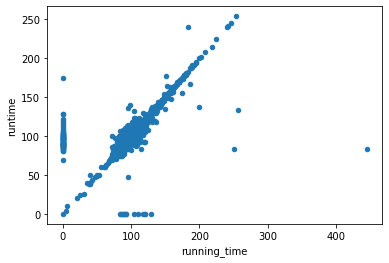

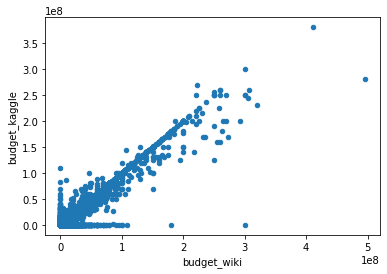

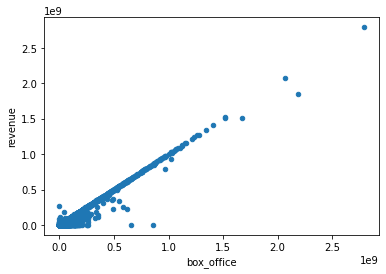

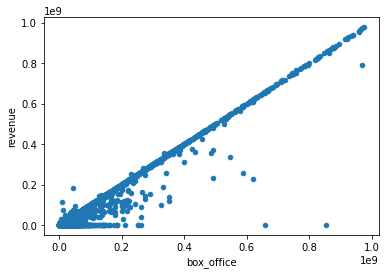

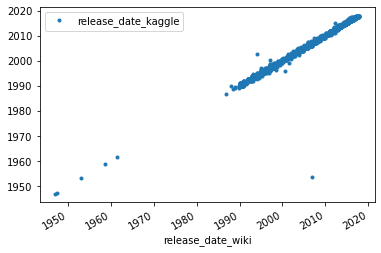

In [5]:
# 11. Set the three variables equal to the function created in D1.
wiki_file, kaggle_file, ratings_file = extract_transform_load()

In [6]:
# 12. Set the DataFrames from the return statement equal to the file names in Step 11. 
wiki_movies_df = wiki_file
movies_with_ratings_df = kaggle_file
movies_df = ratings_file

In [7]:
# 13. Check the wiki_movies_df DataFrame. 
wiki_movies_df.head()

,url,year,imdb_link,title,Based on,Starring,Narrated by,Cinematography,Release date,Country,...,Recorded,Venue,Label,Animation by,Color process,imdb_id,box_office,budget,release_date,running_time
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...","Andrew ""Dice"" Clay",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",United States,...,NaN,NaN,NaN,NaN,NaN,tt0098987,21400000.0,20000000.0,1990-07-11,102.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",NaN,Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",United States,...,NaN,NaN,NaN,NaN,NaN,tt0098994,2700000.0,6000000.0,1990-05-17,114.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",NaN,Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",United States,...,NaN,NaN,NaN,NaN,NaN,tt0099005,57718089.0,35000000.0,1990-08-10,113.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",NaN,Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",United States,...,NaN,NaN,NaN,NaN,NaN,tt0099012,7331647.0,12000000.0,1990-12-25,106.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",NaN,Russell Boyd,"December 19, 1990",US,...,NaN,NaN,NaN,NaN,NaN,tt0099018,6939946.0,25000000.0,1990-12-19,95.0


In [8]:
# 14. Check the movies_with_ratings_df DataFrame.
movies_with_ratings_df.head()

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,rating_0.5,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5.0
0,tt0098987,9548,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane,Kojak. Columbo. Dirty Harry. Wimps.,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,104.0,49000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt0098994,25501,"After Dark, My Sweet","After Dark, My Sweet",All they risked was everything.,NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,114.0,6000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0099005,11856,Air America,Air America,The few. The proud. The totally insane.,NaN,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,112.0,35000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0099012,8217,Alice,Alice,NaN,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,102.0,12000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0099018,25943,Almost an Angel,Almost an Angel,Who does he think he is?,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,95.0,25000000.0,...,3.0,0.0,3.0,2.0,5.0,26.0,37.0,46.0,16.0,11.0


In [9]:
# 15. Check the movies_df DataFrame. 
movies_df.head()

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,production_countries,distributor,producers,director,starring,cinematography,editors,writers,composers,based_on
0,tt0098987,9548,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane,Kojak. Columbo. Dirty Harry. Wimps.,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,104.0,49000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",20th Century Fox,"[Steve Perry, Joel Silver]",Renny Harlin,"[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,Michael Tronick,"[David Arnott, James Cappe]","[Cliff Eidelman, Yello]","[Characters, by Rex Weiner]"
1,tt0098994,25501,"After Dark, My Sweet","After Dark, My Sweet",All they risked was everything.,NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,114.0,6000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",Avenue Pictures,"[Ric Kidney, Robert Redlin]",James Foley,"[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,Howard E. Smith,"[James Foley, Robert Redlin]",Maurice Jarre,"[the novel, After Dark, My Sweet, by, Jim Thom..."
2,tt0099005,11856,Air America,Air America,The few. The proud. The totally insane.,NaN,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,112.0,35000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",TriStar Pictures,Daniel Melnick,Roger Spottiswoode,"[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[John Bloom, Lois Freeman-Fox]","[John Eskow, Richard Rush]",Charles Gross,"[Air America, by, Christopher Robbins]"
3,tt0099012,8217,Alice,Alice,NaN,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,102.0,12000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",Orion Pictures,Robert Greenhut,Woody Allen,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,Susan E. Morse,Woody Allen,NaN,NaN
4,tt0099018,25943,Almost an Angel,Almost an Angel,Who does he think he is?,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,95.0,25000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",Paramount Pictures,John Cornell,John Cornell,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,David Stiven,Paul Hogan,Maurice Jarre,NaN
